# Users geolocation
In this notebook we geolocate the users, through the georeferenced subreddits.
We associate each string of subreddit names to our geolocator, that associate strings to geographical location.
We correct spurious associations, remove mismatches and keep only the subreddits located in US and Canada.
An author will be assigned to a US state (or Canada province) YY if all the georeferenced subreddits he wrote in refer to YY.

In [1]:
import numpy as np
import pandas as pd
import sys

sys.path += ['../src/']
import climact_utils as cu
from glob import glob
import sys
import json
import spark_init
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sc = spark_init.spark_context()
sql_context = spark_init.sql_context(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/opt/spark//python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Load Data

In [2]:
subreddits_geolocation = pd.read_csv(cu.data_path + "US_CA_subreddit_geolocation.csv", index_col = 0)
df_strong = pd.read_csv(cu.data_path + "author_list_subreddit_class/strong_authors_cohort_subreddit_class.csv", index_col = 0)
df_control = pd.read_csv(cu.data_path + "author_list_subreddit_class/control_authors_cohort.csv", index_col = 0)
df_authors = pd.concat([df_control, df_strong])[["author", "subreddit_class"]]


In [3]:
len(subreddits_geolocation)

311

In [25]:
# DataFrame with subreddit - country - admin1code (referring to US state or Canada provinces)
subreddits_geolocation.head()

,subreddit,country,admin1code,region
0,boston,US,MA,Massachusetts
1,massachusetts,US,MA,Massachusetts
2,Somerville,US,MA,Massachusetts
3,wayland,US,MA,Massachusetts
4,Waltham,US,MA,Massachusetts


In [26]:
# dataframe of authors and subreddit_class, that is the type of activation
# nan are the authors in control group
df_authors.sample(6)

,author,subreddit_class
633746,Pikachu62999328,NaN
3929,thowy256899754346,activism
472405,itryanditryanditry,NaN
537917,vectorama,NaN
505358,Maxawelk,NaN
20160,funkywinkerbean45,discussion


### Monthly author georeferences

In [27]:
# need to rename pd.DataFrame.items for converting pandas df to spark for pandas >= 2.0
pd.DataFrame.iteritems = pd.DataFrame.items

In [28]:
# transform the Pandas dataframes into a spark dataframes
author_class_df = sql_context.createDataFrame(df_authors[["author", "subreddit_class"]].astype(str))
subreddits_geolocation_df = sql_context.createDataFrame(subreddits_geolocation.astype(str))

In [29]:
# i join author subreddit dataframe with subreddit geolocation 
# broadcast is used to join a large dataframe with a small one
# the small one is replicated in each parallel process
# then count the number of comments/submission per author per region
(
    sql_context.read.parquet(sorted(glob(cu.data_path + "histories_strong_activated_and_control/*"))[40])
        .select(["author", "subreddit"])
        .join(F.broadcast(subreddits_geolocation_df), "subreddit", "inner")
        .join(F.broadcast(author_class_df), "author", "inner")
        .groupby(["author", "country", "admin1code"])
        .count()
        .toPandas()
    )

,author,country,admin1code,count
0,Sxeptomaniac,US,CA,12
1,AKraiderfan,US,PA,75
2,uselessartsdegree,US,NY,8
3,OriginalPostSearcher,US,OR,6
4,BooYeah0484,US,TX,21
...,...,...,...,...
1507,KingOfVermont,US,VT,1
1508,katerific,US,GA,2
1509,wescowell,US,IL,2
1510,Deerscicle,US,MN,1


In [1]:
# save them for each month
for file in sorted(glob(cu.data_path + "histories_strong_activated_and_control/RS*")):
    print(file)
    try:
        (
            sql_context.read.parquet(file)
            .select(["author", "subreddit"])
            .join(F.broadcast(subreddits_geolocation_df), "subreddit", "inner")
            .join(F.broadcast(author_class_df), "author", "inner")
            .groupby(["author", "country", "admin1code"])
            .count()
        ).toPandas().to_csv(cu.data_path + f"geolocation_histories/{file.replace('.', '/').split('/')[-2]}.csv.gzip", compression = "gzip")
    except:
        print(file, "NOT OPEN")

### Total author georeferences

In [4]:
# concatenate all the monthly dataframes we saved, to count the total number of comments/submissions per author 
authors_admin1codes = (pd.concat([pd.read_csv(file, compression = "gzip", index_col = 0) for file in glob(cu.data_path + "geolocation_histories/*")])
                       .groupby(["author", "country", "admin1code"]).sum().reset_index())

In [5]:
# count the number of different admin1code (region) assigned per author
# and keep only the authors that wrote in only one admin1code
geolocated_authors_df = authors_admin1codes[authors_admin1codes["author"].isin(authors_admin1codes.groupby("author").count().query("admin1code == 1").index)]

In [33]:
geolocated_authors_df.to_csv(cu.data_path + "geolocated_users_window.csv")

In [9]:
print("Proportion geolocated authors", round(len(geolocated_authors_df) / len(df_authors["author"].unique()), 3))

Proportion geolocated authors 0.247


### Real population vs georeferenced usrs

In [2]:
# Load data about us and canada populations
df_canada_provinces = pd.DataFrame([row.split('"')[:2] for row in pd.read_csv(cu.data_path + "canada_population_provinces.csv", header = 8, sep = ";", 
                                                                              names = ["cols"])["cols"][:14]], columns = ["PROVINCE", "POPULATION"])
df_canada_provinces = (df_canada_provinces.assign(region = lambda x: [u[:-3] if "2" in u else u[:-1] for u in x["PROVINCE"]],
                                                  population = lambda x: [int("".join([k for k in u if k != ","])) for u in list(x["POPULATION"])])
                                                  .merge(pd.DataFrame([{
                                                      'Newfoundland and Labrador':5,
                                                      'Nova Scotia':7,
                                                      'New Brunswick':4,
                                                      'Quebec': 10,
                                                      'Ontario':8,
                                                      'Manitoba':3,
                                                      'Saskatchewan':11,
                                                      'Alberta':1, 
                                                      'British Columbia':2,
                                                      'Northwest Territories':13}])
                                                      .T.reset_index()
                                                      .rename(columns = {"index": "region",0: "admin1code", "POPULATION": "population"}))[["region", "population", "admin1code"]]
                                                      .assign(country = "CA"))

pop_data = (pd.read_csv(cu.data_path + "geo_data/US_POPULATION_STATE.csv", sep = ";")[["State", "01/07/23"]]
            .rename(columns = {"01/07/23": "Population"})
            .iloc[:51].assign(State = lambda x: [u[1:] for u in x["State"]], 
                              Population = lambda x: [int("".join(u.split("."))) 
                                                      for u in x["Population"]]))

subreddits_geolocation = pd.read_csv(cu.data_path + "US_CA_subreddit_geolocation.csv", index_col = 0)


In [3]:
pop_data = pd.read_csv(cu.data_path + "geo_data/US_POPULATION_STATE.csv", sep = ";")[["State", "01/07/23"]].rename(columns = {"01/07/23": "Population"}).iloc[:51].assign(State = lambda x: [u[1:] for u in x["State"]], Population = lambda x: [int("".join(u.split("."))) for u in x["Population"]])

In [4]:
# load data about georeferences in our dataset
admin1code_population = pd.concat([(pop_data.rename(columns = {"State": "region", "Population": "population"}).merge(subreddits_geolocation.query("country == 'US'").groupby("region").first()[["admin1code", "country"]].reset_index(), how = "outer")).dropna(),
                                   df_canada_provinces])
admin1code_population["admin1code"] = admin1code_population["admin1code"].astype(str)

In [5]:
geolocated_authors_df = pd.read_csv(cu.data_path + "geolocated_users_window.csv", index_col = 0)

In [6]:
# merge real and georeferenced population 
real_vs_reddit_population = geolocated_authors_df.groupby(["country", "admin1code"]).count()["author"].reset_index().merge(admin1code_population).rename(columns = {"author": "reddit_population", "population": "real_population"})

In [7]:
mypalette = [sns.color_palette("bright")[3], sns.color_palette("dark")[0]]

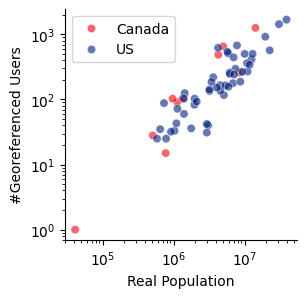

In [12]:
fig, axes = plt.subplots(figsize = (3,3))

sns.scatterplot(real_vs_reddit_population.replace({"CA": "Canada"}),
                x = "real_population",
                y = "reddit_population",
                hue = "country",
                palette = mypalette,
                alpha = 0.6
                )


axes.set_xscale("log")
axes.set_yscale("log")

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(title = "")
axes.set_xlabel("Real Population")
axes.set_ylabel("#Georeferenced Users")

fig.savefig(f"../paper/georeferences.pdf", format = "pdf", bbox_inches = "tight")
